# Homework 1, MSBC.5190 Modern Artificial Intelligence S23

**Teammates: Kersti Kammerer, Wes Weber, Alyssa Duke

**Teamname: Team1**

Handout 02/10/2023 4pm, **due 02/24/2022 by 4pm**. Please submit through Canvas. Each team only needs to submit one copy.

Important information about submission:
- Write all code, text (answers), and figures in the notebook.
- Please make sure that the submitted notebook has been run and the cell outputs are visible.
- Please print the notebook as PDF and submit it together with the notebook. Your submission should contain two files: `homework1-teamname.ipynb` and `homework1-teamname.pdf`

In this homework, we will build and train convolutional neural networks (CNN) on a subset of [Kaggle "cats vs. dog"](https://www.kaggle.com/c/dogs-vs-cats) classification data. The goal of the homework are four folds:


1.   Train a small CNN from scratch as a baseline 
2.   Improve the baseline model. You can find some hints in the last section.
3.   Implement transfer learning: fine-tune top layers of a pre-trained network
4.   Experiment and develop a better model (i.e., better accuracy). You can find some hints in the last section.

First, import the packages or modules required for this homework.

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# Import packages or modules                                                   #
################################################################################
import numpy as np
import matplotlib.pyplot as plt
import keras

# TODO: Fill in your code
# Import relevant packages
# https://keras.io/guides/sequential_model/
# https://keras.io/api/layers/
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D

## Obtain and Organize the Data Sets

The competition data is divided into training set (25,000 images) and testing set (10,000 images). For this homework, we are going to use 4,000 images (2,000 cat images and 2,000 dog images) from the original training data for training, 1,000 images for validation, and 1,000 images for testing.


### Download the Data Set###
The small data set `dogs-vs-cats-small.zip` can be downloaded through Canvas. After downloading the data, upload it to Google Colab. The easiest way to do it is to use the upload option at the top of the file-explorer pane. Note that files uploaded in this way are uploaded to the running instance and will be deleted when the session is disconnected. Alternatively, you can also upload the data set to your Google Drive and mount your Google Drive to Colab. (More info: https://colab.research.google.com/notebooks/io.ipynb)


### Unzip the Data Set###


In [ ]:
!unzip ./dogs-vs-cats-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: dogs-vs-cats-small/train/cat/cat.1000.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1001.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1002.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1003.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1004.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1005.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1006.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1007.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1008.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1009.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.101.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1010.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1011.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1012.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1013.jpg  
  inflating: dogs-vs-cats-small/train/cat/cat.1014.jpg  
  inflating: dogs-vs-cats-small/train/

Here, I assume that you upload `dogs-vs-cats-small.zip` to the running instance of Google Colab. I have already organized the data to training, validation, and testing dataset. Under each of the data directories, each subdirectory represent a class and contains images from that class. After unzipping, you will find the training, validation, and testing data set in the following paths:

* dogs-vs-cats-small/
  * train/
    * cat/
    * dog/
  * validation/
    * cat/
    * dog/
  *test/
    * cat/
    * dog/


### Read and Preprocess the Data

We use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to load images on the fly from disk. You can use and modify it later to perform random data augmentations to improve model performance. Here, we rescale the data to between 0 and 1 (by multiplying by 1/255)

Note: Here we are following our textbook and use ImageDataGenerator to load images and perform data augmentation. Alternatively, you can also use tf.keras.utils.image_dataset_from_directory. 

*   https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
*   https://www.tensorflow.org/tutorials/load_data/images




In [ ]:
data_dir = './dogs-vs-cats-small/'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Instantiate three image generator classes:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last')

valid_datagen = ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last')

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last'
)

In [ ]:
batch_size=32
train_generator = train_datagen.flow_from_directory(
    directory=data_dir + 'train',
    target_size=(224, 224),
    classes=['cat','dog'],
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)

valid_generator = valid_datagen.flow_from_directory(
    directory=data_dir + 'validation',
    target_size=(224, 224),
    classes=['cat','dog'],
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=data_dir + 'test',
    target_size=(224, 224),
    classes=['cat','dog'],
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 1. Build and Train a Baseline Model (40%)

We will start with building a simple convolutional neural network. 

### Define the model

Please define a model with the following layers and hyperparameters.
* Input image: 224 (height) x 224 (width) x 3 (channels)
* Convolution: 16 kernels (size = 3 x 3), stride = 1, padding = 1
* MaxPool: kernel size = 2 x 2, stride = 2, padding = 0
* Convolution: 32 kernels (size = 3 x 3), stride = 1, padding = 1
* MaxPool: kernel size = 2 x 2, stride = 2, padding = 0
* Convolution: 64 kernels (size = 3 x 3), stride = 1, padding = 1
* MaxPool: kernel size = 2 x 2, stride = 2, padding = 0
* Dense: 128 fully connected neurons
* Output: 1 of 2 classes (cat or dog)


In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# Define the model                                                             #
################################################################################
model = Sequential()
model.add(Conv2D(16,kernel_size = (3,3), strides = (1,1), activation ="relu", padding = "same", 
                 input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = "valid"))
model.add(Conv2D(32, kernel_size = (3,3), strides = (1,1), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid"))
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid"))
model.add(Flatten())
model.add(Dense(128, activation = "tanh"))
model.add(Dense(2, activation = "softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

**Inline Question #1:** Notice the output shape and # of param of each layer

- What is the output shape of the first convolutional layer and how to calculate it?
- What is the # of params of the first convolutional layer and how to calculate it?

**Your Answer:** The output shape of the first convolutional layer is (None, 224, 224, 16). "None" refers to the batch size, which means this dimension is variable and the network does not know the batch size in advance. Once the data is fit, "None" would be replaced by the batch size we give it while training. You can calculate the second two dimensions, the width and height of the output shape with the formula: (input_dimension – kernel_size + 2 * padding) / stride + 1, or in this case: (224 - 3 + (2 * 1)) / 1 + 1 = 224. The fourth dimension of the output shape represents the number of kernels or filters used in the layer, which is 16. 

The # of params in the first layer is calculated with the weights and bias of the first layer. We multiply 3 * 3 * 3 (the size of the kernel) * 16 ( the number of kernels) + 16 (the number of biases) to get the number of parameters, 448.

### Configure and Train the Baseline Model

Please use Adam as the optimizer and keep track of accuracy metric.

**Inline Question #2:** What loss function will you choose for this classfication problem?

**Your Answer:** We are using categorical cross entropy because it is commonly used in classification problems. Categorical cross entropy measures dissimilarity between the true class and predicted class. Furthermore, because we used the softmax activation function, we cannot use binary cross-etnropy because it would lead to incorrect interpretation of the model output.

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# Configure and train the model (set number of epochs to 10)                   #
################################################################################
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
125/125 [==============================] - 28s 138ms/step - loss: 0.8240 - accuracy: 0.5475 - val_loss: 0.6418 - val_accuracy: 0.6340
Epoch 2/10
125/125 [==============================] - 19s 153ms/step - loss: 0.5959 - accuracy: 0.6898 - val_loss: 0.5812 - val_accuracy: 0.6890
Epoch 3/10
125/125 [==============================] - 18s 145ms/step - loss: 0.5022 - accuracy: 0.7525 - val_loss: 0.5607 - val_accuracy: 0.7120
Epoch 4/10
125/125 [==============================] - 18s 141ms/step - loss: 0.4562 - accuracy: 0.7803 - val_loss: 0.6090 - val_accuracy: 0.6810
Epoch 5/10
125/125 [==============================] - 18s 142ms/step - loss: 0.3645 - accuracy: 0.8345 - val_loss: 0.6079 - val_accuracy: 0.7250
Epoch 6/10
125/125 [==============================] - 18s 140ms/step - loss: 0.2922 - accuracy: 0.8710 - val_loss: 0.6924 - val_accuracy: 0.7150
Epoch 7/10
125/125 [==============================] - 17s 133ms/step - loss: 0.2115 - accuracy: 0.9075 - val_loss: 0.8479 - val_ac

**Inline Question #3:** Please draw loss and accuracy learning curves on the training and validation set.
- Please explain your observation of the learning curves.

**Your Answer:** It appears that our model is overfitting due to the gap between the training accuracy and loss and the validation accuracy and loss. The accuracy in our training data is higher and the loss is lower while accuracy in the validation data is lower and loss is higher. It also appears that the validation accuracy does not improve after the fourth epoch while loss exponentially increases. After 1 epoch, the model begins to overfit.

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# Draw learning curves                                                         #
################################################################################
def plot_learning_curve(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

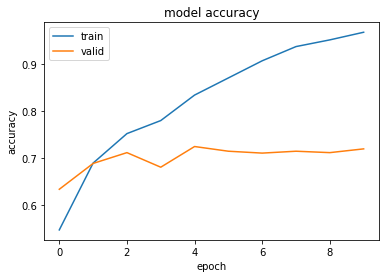

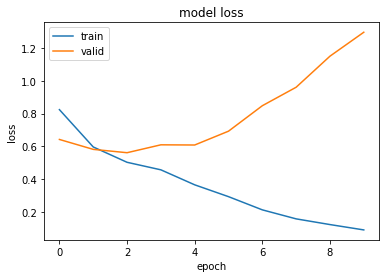

In [ ]:
plot_learning_curve(history)

### Evaluate Model Performance

**Inline Question #4:** What is the accuracy on the test dataset?

**Your Answer:** The test accuracy is 68.2%.



In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# Calculate accuracy on the test data set                                      #
################################################################################
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {round(test_acc * 100,2)}%")

32/32 [==============================] - 3s 94ms/step - loss: 1.5938 - accuracy: 0.6820
Test accuracy: 68.2%


## Improve the Baseline Model (10%)

**Inline Question #5:** Please propose and implement one improvement on the baseline model. 
* What is the rational for the proposed improvement?
* Did it help? Please present your evidence.

**Your Answer:** 
1. We added a combination of a dropout layer after our dense layer and regularization to our dense layer. The dropout layer randomly drops out some of the neurons during training, which can reduce the sensitivity of the model to individual neurons and can help increase generalizability and reduce overfitting, which we found to be an issue in the baseline model. Regularization adds a penality that encourages weights to be small and also helps prevent overfitting. We also tried adding dropout and regularization, each on their own, but neither improved the model as much as the combination of them together. We also tried adding an extra dense layer, but this decreased validation accuracy.  

2. Our changes did help improve the baseline model, because the test accuracy increased by 6.3%, to approximately 74.5%. We also see less overfitting, as the training and validation accuracies and losses in the learning curves are closer together than the previous model.  

In [ ]:
from keras import regularizers

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# You need to finish three things                                              #
# 1. Implement the model improvement                                           #
# 2. Draw learning curves                                                      #
# 3. Evaluate model performance on test data                                   #
# Note: You do not have to put all the codes in this cell and can write in     #
# multiple cells.                                                              #
################################################################################
model2 = Sequential()
model2.add(Conv2D(16,kernel_size = (3,3), strides = (1,1), activation ="relu", padding = "same", 
                 input_shape = (224,224,3)))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (2,2), padding = "valid"))
model2.add(Conv2D(32, kernel_size = (3,3), strides = (1,1), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid"))
model2.add(Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid"))
model2.add(Flatten())
model2.add(Dense(128, activation = "tanh", kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation = "softmax"))



In [ ]:
model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
history2 = model2.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
125/125 [==============================] - 19s 135ms/step - loss: 1.2968 - accuracy: 0.5260 - val_loss: 0.7611 - val_accuracy: 0.5860
Epoch 2/10
125/125 [==============================] - 18s 142ms/step - loss: 0.7121 - accuracy: 0.5790 - val_loss: 0.7191 - val_accuracy: 0.5410
Epoch 3/10
125/125 [==============================] - 17s 136ms/step - loss: 0.7101 - accuracy: 0.6045 - val_loss: 0.7181 - val_accuracy: 0.6240
Epoch 4/10
125/125 [==============================] - 18s 145ms/step - loss: 0.7088 - accuracy: 0.6668 - val_loss: 0.7450 - val_accuracy: 0.6520
Epoch 5/10
125/125 [==============================] - 18s 141ms/step - loss: 0.7192 - accuracy: 0.6482 - val_loss: 0.7182 - val_accuracy: 0.6670
Epoch 6/10
125/125 [==============================] - 17s 133ms/step - loss: 0.7012 - accuracy: 0.6833 - val_loss: 0.6979 - val_accuracy: 0.6860
Epoch 7/10
125/125 [==============================] - 18s 140ms/step - loss: 0.7229 - accuracy: 0.7120 - val_loss: 0.6639 - val_ac

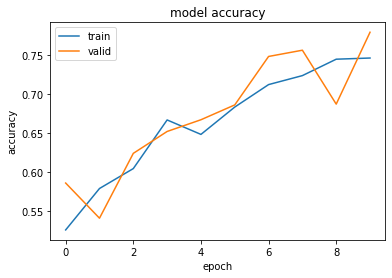

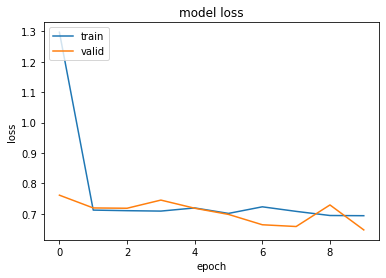

In [ ]:
plot_learning_curve(history2)

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator)
print(f"Test accuracy: {round(test_acc * 100,2)}%")

32/32 [==============================] - 3s 95ms/step - loss: 0.7118 - accuracy: 0.7450
Test accuracy: 74.5%


## 3. Transfer Learning (30%)

Next, we are going to fine-tune [VGG19](https://arxiv.org/abs/1409.1556) on our small dogs-vs-cats dataset. Specifically, we will load the VGG19 model pre-trained on ImageNet, freeze its weights, add some new layers on top of the frozen layers from VGG19, and train the new layers on our dataset. You need to add an output classification layer on top of the base VGG19 model. Please also add a `Dropout` layer with dropout rate = 0.5 before the classification layer for regularization.

**Inline Question #6:** Please implement the transfer learning, draw learning curves, and report model performance on test data.  
* Please explain your observation of the learning curves.
* What is the model performance on the test data? Is the better than the baseline model? Why is the performance better or worse than before?


**Your Answer:** 
1. The learning curves still show a little bit of overfitting, since there is a gap between the training accuracy and testing accuracy. It also appears that there is not much improvement of the validation accuracy across epochs. However, the accuracy on both the training and validation data is much higher than the previous models. 
2. The VGG19 model performance on the test data is 86.7% which is 12.2% higher than our improved baseline model. Performance is better because VGG19 is a well-established model that generalizes well to other datasets. It was produced by a reputable and trusted team at Oxford and utilizes small 3x3 convolution filters and deeper networks, which allows it to capture complex features and perform well on object detection/recognition tasks. Furthermore, this network was trained on the ImageNet dataset, which contains over a million images. Therefore, the model can simply be fine-tuned for specific tasks on smaller datasets, which in this case is correctly identifying cats and dogs. 
Citations: [VGG19](https://nnart.org/why-is-vgg-commonly-used/)
[Transfer Learning](https://towardsdatascience.com/how-transfer-learning-can-be-a-blessing-in-deep-learning-models-fbc576dc42#:~:text=The%20accuracy%20of%20Transfer%20Learning,just%20so%20simple%20and%20easy.)

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# You need to finish three things                                              #
# 1. Implement transfer learning: define, configure, and train model           #
# 2. Draw learning curves                                                      #
# 3. Evaluate model performance on test data                                   #
# Note: You do not have to put all the codes in this cell and can write in     #
# multiple cells.                                                              #
################################################################################
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg19.layers:
    layer.trainable = False
model_t = Sequential()
model_t.add(vgg19)
model_t.add(Flatten(name='flattened'))
model_t.add(Dropout(0.5, name='dropout'))
model_t.add(Dense(2, activation='softmax', name='predictions'))

In [ ]:
model_t.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_t = model_t.fit(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
125/125 [==============================] - 33s 231ms/step - loss: 0.4927 - accuracy: 0.8040 - val_loss: 0.2159 - val_accuracy: 0.9090
Epoch 2/10
125/125 [==============================] - 27s 214ms/step - loss: 0.2782 - accuracy: 0.8838 - val_loss: 0.2217 - val_accuracy: 0.9070
Epoch 3/10
125/125 [==============================] - 26s 204ms/step - loss: 0.1994 - accuracy: 0.9122 - val_loss: 0.2077 - val_accuracy: 0.9120
Epoch 4/10
125/125 [==============================] - 26s 207ms/step - loss: 0.1444 - accuracy: 0.9375 - val_loss: 0.2028 - val_accuracy: 0.9210
Epoch 5/10
125/125 [==============================] - 26s 205ms/step - loss: 0.1243 - accuracy: 0.9495 - val_loss: 0.2961 - val_accuracy: 0.8820
Epoch 6/10
125/125 [==============================] - 26s 204ms/step - loss: 0.1137 - accuracy: 0.9557 - val_loss: 0.2201 - val_accuracy: 0.9190
Epoch 7/10
125/125 [==============================] - 26s 206ms/step - loss: 0.1112 - accuracy: 0.9535 - val_loss: 0.2010 - val_ac

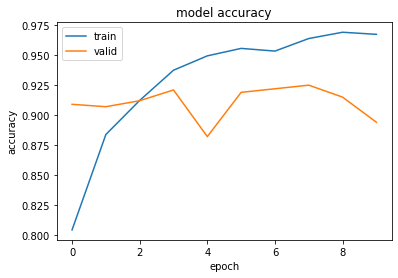

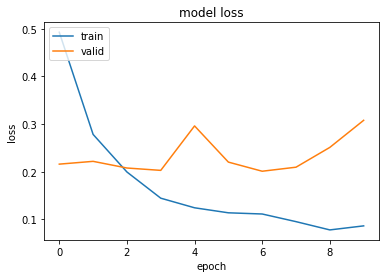

In [ ]:
plot_learning_curve(history_t)

In [ ]:
test_loss, test_acc = model_t.evaluate(test_generator)
print(f"Test accuracy: {round(test_acc * 100,2)}%")

32/32 [==============================] - 6s 167ms/step - loss: 0.4363 - accuracy: 0.8670
Test accuracy: 86.7%


## 4. Winning Model and Model Performance (20%)

You probably have noticed that transfer learning achieved a better prediction performance on the test data. In this section, please experiment with more ideas to further improve model performance. 

When experimenting with different model improvement ideas, please only use training and validation data. After you selecting a winning model based on its performance on the validation data, evaluate the winning model's performance on the test data and report it here.

Note that this section is worth 20% of your total grade. Half of it (i.e., 10%) is based on implementation (i.e., implement one improvement) and the other half is based on performance. Teams with higher performance scores get higher grade. 

If you experiment with more than one idea, you do not need to submit all experiment codes and results but just the winning one. You can definitely talk about them in the answers below. 


**Inline Question #7:** How would you improve the model performance further?  
* What did you try and what did you find?
* What is the rational behind the winning model?
* What is the winning model's performance on the test data?

1. Since our model still seemed to overfit, we added data augmentation to randomly rotate the images within a 30 degree range and to also randomly flip the images horizontally. Data augmentation allows us to train the model with more data, which can also help reduce overfitting. We tried training the model with 8 epochs, and also adding L2 regularization to the output layer, but both of these methods slightly decreased validation accuracies, so we decided not to include these. Next, we added a batch normalization layer to the vgg19 model, because it discourages overfitting by adding noise to the inputs of a layer. This combination of data augmentation and batch normalization yielded the best validation accuracies in addition to a smaller gap between the training and validation learning curves. 
2. The rational behind the winning model is that because vgg19 was carefully designed by experts, it is able to perform better than the model we built and tuned. By utilizing data augmentation and batch normalization, we were able to reduce overfitting even more in the vgg19 model. Our learning curves show that we have reduced overfitting, because our validation accuracy is now higher than training accuracy, and the loss is lower.   
3. The winning model's performance on the test data is 89.6%, which is more than a 20% increase from our original baseline model, and a 2.9% improvement over the original vgg19 model.

In [ ]:
################################################################################
# TODO: Fill in your codes                                                     #
# You need to include three things                                             #
# 1. Implement one improvement of the model                                    #
# 2. Draw learning curves                                                      #
# 3. Evaluate model performance on test data                                   #
# Note: You do not have to put all the codes in this cell and can write in     #
# multiple cells.                                                              #
################################################################################
train_datagen2 = ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last',
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='reflect')

train_generator2 = train_datagen2.flow_from_directory(
    directory=data_dir + 'train',
    target_size=(224, 224),
    classes=['cat','dog'],
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)


Found 4000 images belonging to 2 classes.


In [ ]:
for layer in vgg19.layers:
    layer.trainable = False
model_t2 = Sequential()
model_t2.add(vgg19)
model_t2.add(BatchNormalization())
model_t2.add(Flatten(name='flattened'))
model_t2.add(Dropout(0.5, name='dropout'))
model_t2.add(Dense(2, activation='softmax', name='predictions'))

In [ ]:
model_t.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_t2 = model_t.fit(train_generator2, validation_data=valid_generator, epochs = 10)

Epoch 1/10
125/125 [==============================] - 72s 499ms/step - loss: 0.6242 - accuracy: 0.7623 - val_loss: 0.2434 - val_accuracy: 0.8950
Epoch 2/10
125/125 [==============================] - 60s 482ms/step - loss: 0.3394 - accuracy: 0.8550 - val_loss: 0.2571 - val_accuracy: 0.8900
Epoch 3/10
125/125 [==============================] - 61s 482ms/step - loss: 0.3120 - accuracy: 0.8665 - val_loss: 0.2461 - val_accuracy: 0.8880
Epoch 4/10
125/125 [==============================] - 61s 485ms/step - loss: 0.3241 - accuracy: 0.8702 - val_loss: 0.2549 - val_accuracy: 0.8970
Epoch 5/10
125/125 [==============================] - 61s 489ms/step - loss: 0.3176 - accuracy: 0.8725 - val_loss: 0.2126 - val_accuracy: 0.9140
Epoch 6/10
125/125 [==============================] - 61s 488ms/step - loss: 0.2894 - accuracy: 0.8848 - val_loss: 0.1912 - val_accuracy: 0.9250
Epoch 7/10
125/125 [==============================] - 61s 487ms/step - loss: 0.2841 - accuracy: 0.8885 - val_loss: 0.2573 - val_ac

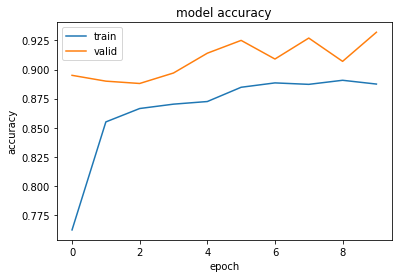

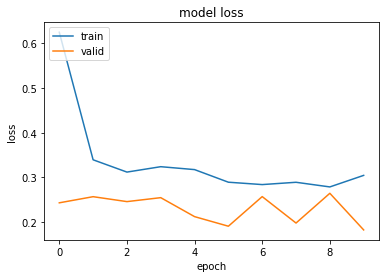

In [ ]:
plot_learning_curve(history_t2)

In [ ]:
test_loss, test_acc = model_t.evaluate(test_generator)
print(f"Test accuracy: {round(test_acc * 100,2)}%")

32/32 [==============================] - 5s 153ms/step - loss: 0.3151 - accuracy: 0.8960
Test accuracy: 89.6%


## Hints to Improve Model Performance


*   Try different batch_size and num_epochs
*   Try batch normalization, dropout, regularization (check textbook DIL Chapter 9 "Unstable Gradients", "Modern Generalization")
*   Try different optimzers, learning_rate (e.g., learning rate decay, check textbook DIL Chapter 9 "Fancy Optimizers")
*   Try data augmentation using ImageDataGenerator (check textbook DIL Chapter 9 "Data Augmentation" and Chapter 10 Example 10.8)
*   Try different pre-trained models (check https://keras.io/api/applications/)
*   Try a round of fine-tuning of the entire model instead of just the final classification layer (check https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow)
*   You probably need to use `tf.keras.callbacks.ModelCheckpoint` and `tf.keras.callbacks.EarlyStopping` to help decide when to stop training and store the best model. https://keras.io/api/callbacks/

